# Evaluate different architecture

Here we set up the infrasturcture to evaluate different TaylorNets aginst Multi-Layer Perceptrons (MLPs) and ResNet.


In [1]:
# Import all necessary packages
import torch
from torch.utils.data.dataset import Dataset
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Data generation (optional)
First we generate the train and test data and save it on file

In [2]:
## Generate the data and save to file
## The data are generated in the cube (-1,1) X (-1,1)

def separatrix(x1,x2):
    return x2[:]*x2[:]+x1[:]*x1[:]-0.7

class DATA():
    def __init__(self,n_sample=100,noise_strenght = 0.0):

        self.label_xy = np.zeros((n_sample,3),dtype=float)
        self.label_xy[:,1]=2*np.random.rand(n_sample)-1   # x is between -1 and 1
        self.label_xy[:,2]=2*np.random.rand(n_sample)-1 # y is between -1 and 1
    
        if(noise_strenght>0.0):
            noise=np.random.randn(n_sample)*noise_strenght
            self.label_xy[:,0] = separatrix(self.label_xy[:,1],self.label_xy[:,2]) +noise[:] > 0.0
        else:
            self.label_xy[:,0] = separatrix(self.label_xy[:,1],self.label_xy[:,2]) > 0.0
            
    def visualize(self):
        plt.scatter(self.label_xy[:,1],self.label_xy[:,2],c=self.label_xy[:,0])
            
    def save(self,file_path):
        np.save(file_path, self.label_xy, allow_pickle=False, fix_imports=False)

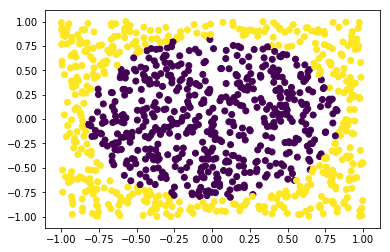

In [3]:
train=DATA(5000,0.1)
test=DATA(1000,0.0)
test.save("./test_data.npy")
train.save("./train_data.npy")
test.visualize()
#test.visualize()

## Next we import the data into a dataloader (mandatory)

In [4]:
class DataSet_for_regression(Dataset):

    def __init__(self,file_path):
        self.data = torch.FloatTensor(np.load(file_path))
    
    def __getitem__(self, index): 
        sample=self.data[index,1:3] #extract the last 2 elements
        label=self.data[index,0]    # extract the first element
        return (sample, label)
    
    def __len__(self):
        return self.data.shape[0]
    
train_data = DataSet_for_regression("./train_data.npy")
test_data  = DataSet_for_regression("./test_data.npy")

BATCH= 10
USE_CUDA=False
kwargs = {'num_workers': 1, 'pin_memory': USE_CUDA}
train_loader = torch.utils.data.DataLoader(dataset=train_data,batch_size=BATCH, 
                                           shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(dataset=test_data,batch_size=BATCH, 
                                          shuffle=False, **kwargs)

## Next we define the Multi-Layer Perceptron (Mandatory)

In [5]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.utils import save_image
import torch.optim as optim
from torch import nn
import collections

def order_dict_from_list(list_of_dims):
    OD = collections.OrderedDict()
    for i in range(len(list_of_dims)-2):
        in_dim=list_of_dims[i]
        out_dim=list_of_dims[i+1]
        name_layer = "layer"+str(i+1)
        name_activation = "relu"+str(i+1)
        OD[name_layer] = torch.nn.Linear(in_dim,out_dim)
        OD[name_activation] = nn.ReLU()
    # Add the last layer
    in_dim=list_of_dims[-2]
    out_dim=list_of_dims[-1]
    name_layer = "output"
    name_activation = "sigmoid"
    OD[name_layer] = torch.nn.Linear(in_dim,out_dim)
    OD[name_activation] = nn.Sigmoid()
    
    return OD
        

# Define the Multi-Layer Perceptron
class MLP(torch.nn.Module):

    def __init__(self,input_dim,hd1,hd2,output_dim):
        super().__init__()
        
        # Auxiliary variables
        self.loss_history = []
        self.epoch = 0
        self.linear1 = torch.nn.Linear(input_dim,hd1)
        self.linear2 = torch.nn.Linear(hd1,hd2)
        self.linear3 = torch.nn.Linear(hd2,output_dim)
    
    def forward(self,x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = torch.sigmoid(self.linear3(x))
        xout = x.view(x.shape[0])
        return xout
    
    def specify_loss(self,criterion):
        self.criterion = criterion
        
    def specify_optimizer(self,optimizer):
        self.optimizer=optimizer
        
    def save_everything(self,filepath):
        state={
            'state_dict': self.state_dict(),
            'loss_history': self.loss_history,
            'epoch': self.epoch
        }
        if(self.optimizer != None):
            state['optimizer_name'] = self.optimizer
            state['optimizer_dict'] = self.optimizer.state_dict()
        if(self.criterion != None):
            state['criterion_name'] = self.criterion
            state['criterion_dict'] = self.criterion.state_dict()
        torch.save(state,filepath)
   
        
    def load_everything(self,filepath):
        state = torch.load(filepath,map_location='cpu')
        self.load_state_dict(state['state_dict'])
        self.loss_history = state['loss_history']
        self.epoch = state['epoch']
        if 'optimizer_name' in state:
            self.optimizer = state['optimizer_name'] 
            self.optimizer.load_state_dict(state['optimizer_dict'])
        if 'criterion_name' in state:
            self.criterion = state['criterion_name']
            self.criterion.load_state_dict(state['criterion_dict'])        
    
    def compute_loss(self, output, labels):
        loss = self.criterion(output,labels)
        return loss
    

 
    def train_one_epoch(self,trainloader):
        tmp = []
        
        for i, data in enumerate(trainloader, 0): #loop over minibatches
            xin, labels = data
            xout = self.forward(Variable(xin))
            loss = self.compute_loss(xout, labels)
            tmp.append(loss.item()) # add the loss to the tmp list
            # For each minibatch set the gradient to zero
            self.optimizer.zero_grad()
            loss.backward()  # do backprop and compute all the gradients
            self.optimizer.step() # update the parameters
            
        # Svae the average loss during the epoch and the final value at the end of epoch
        self.loss_history.append(np.mean(tmp))
        self.epoch += 1
    
    def test_accuracy(self,data_loader):
        with torch.no_grad():
            correct=0
            total=0
            for i, data in enumerate(data_loader, 0): #loop over minibatches
                xin, labels = data
                xout = self.forward(Variable(xin))
                xout = xout>0.5
                ls = labels > 0.5
                count=torch.sum(torch.eq(ls,xout)).item()
                correct += count
                total += ls.shape[0]
            return float(correct)/total
    
input_DIM=2
hd1=6
hd2=6
output_DIM=1

mlp=MLP(input_DIM,hd1,hd2,output_DIM)
mlp.specify_loss(nn.BCELoss(reduction='elementwise_mean'))
mlp.specify_optimizer(optim.Adam(mlp.parameters(), lr=0.0001))


data = next(iter(train_loader))
xin, labels = data
xout = mlp(xin)

[Epoch  10] loss: 0.6347 accuracy: 0.7410
[Epoch  20] loss: 0.5613 accuracy: 0.8160
[Epoch  30] loss: 0.4812 accuracy: 0.8570
[Epoch  40] loss: 0.4061 accuracy: 0.8960
[Epoch  50] loss: 0.3429 accuracy: 0.9470
[Epoch  60] loss: 0.2965 accuracy: 0.9560
[Epoch  70] loss: 0.2629 accuracy: 0.9630
[Epoch  80] loss: 0.2385 accuracy: 0.9640
[Epoch  90] loss: 0.2209 accuracy: 0.9660
[Epoch 100] loss: 0.2076 accuracy: 0.9710
[Epoch 110] loss: 0.1978 accuracy: 0.9720
[Epoch 120] loss: 0.1901 accuracy: 0.9720
[Epoch 130] loss: 0.1843 accuracy: 0.9710
[Epoch 140] loss: 0.1792 accuracy: 0.9730
[Epoch 150] loss: 0.1752 accuracy: 0.9730
[Epoch 160] loss: 0.1721 accuracy: 0.9700
[Epoch 170] loss: 0.1694 accuracy: 0.9720
[Epoch 180] loss: 0.1671 accuracy: 0.9710
[Epoch 190] loss: 0.1652 accuracy: 0.9710
[Epoch 200] loss: 0.1637 accuracy: 0.9720


Text(0,0.5,'Loss')

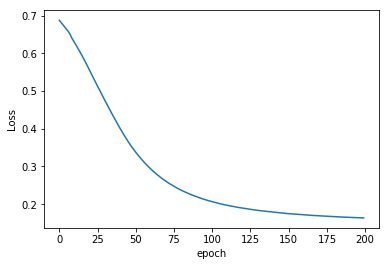

In [6]:
if(mlp.epoch > 100):
    mlp.load_everything('./mlp.pth')

for _ in range(0,200):
    mlp.train_one_epoch(train_loader)
    if(mlp.epoch % 10==0):
        accuracy=mlp.test_accuracy(test_loader)
        print("[Epoch %3d] loss: %.4f accuracy: %.4f" % (mlp.epoch,mlp.loss_history[-1],accuracy))

mlp.save_everything('./mlp.pth')

        
plt.plot(mlp.loss_history)
plt.xlabel("epoch")
plt.ylabel("Loss")

## Viasualize the domanin boundary and the test data

[(-1, 1), Text(0,0.5,'$X_2$'), (-1, 1), Text(0.5,0,'$X_1$'), None]

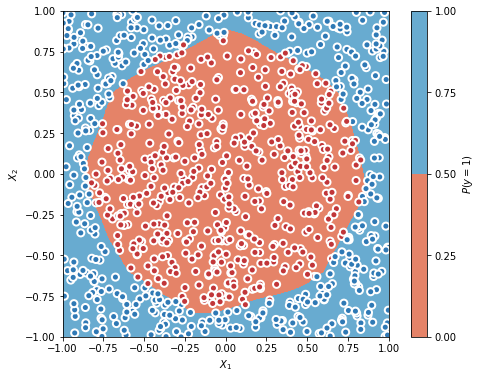

In [7]:
# visualize the decision boundary 

xgrid, ygrid = np.mgrid[-1:1.1:0.1, -1.0:1.1:0.1]
xygrid = np.array([xgrid, ygrid]).transpose(1,2,0)
myinput=torch.Tensor(xygrid.reshape(-1,2))
#     print(myinput.shape)
with torch.no_grad():
    pp=mlp(myinput)
    probs=pp.numpy().reshape(xgrid.shape)

f, ax = plt.subplots(figsize=(8, 6))
contour = ax.contourf(xgrid, ygrid, probs, [0,0.5,1.0], cmap="RdBu", vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

test=np.load("./test_data.npy")
ax.scatter(test[:,1],test[:,2],c=test[:,0], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=2)

ax.set(aspect="equal",
       xlim=(-1, 1), ylim=(-1, 1),
       xlabel="$X_1$", ylabel="$X_2$")

## TaylorNet (Stephen's random thoughts)

In [32]:
from TaylorNet import TaylorNet

# Define the Multi-Layer Perceptron with TaylorNets
class Taylor_MLP(torch.nn.Module):

    def __init__(self,input_dim,output_dim):
        super().__init__()
        
        # Auxiliary variables
        self.loss_history = []
        self.epoch = 0
        self.tnet = TaylorNet(2,3)
        self.linear = torch.nn.Linear(3,1)
    
    def forward(self,x):
        x = self.tnet(x)
        x = torch.sigmoid(self.linear(x))
        xout = x.view(x.shape[0])
        return xout
    
    def specify_loss(self,criterion):
        self.criterion = criterion
        
    def specify_optimizer(self,optimizer):
        self.optimizer=optimizer
        
    def save_everything(self,filepath):
        state={
            'state_dict': self.state_dict(),
            'loss_history': self.loss_history,
            'epoch': self.epoch
        }
        if(self.optimizer != None):
            state['optimizer_name'] = self.optimizer
            state['optimizer_dict'] = self.optimizer.state_dict()
        if(self.criterion != None):
            state['criterion_name'] = self.criterion
            state['criterion_dict'] = self.criterion.state_dict()
        torch.save(state,filepath)
   
        
    def load_everything(self,filepath):
        state = torch.load(filepath,map_location='cpu')
        self.load_state_dict(state['state_dict'])
        self.loss_history = state['loss_history']
        self.epoch = state['epoch']
        if 'optimizer_name' in state:
            self.optimizer = state['optimizer_name'] 
            self.optimizer.load_state_dict(state['optimizer_dict'])
        if 'criterion_name' in state:
            self.criterion = state['criterion_name']
            self.criterion.load_state_dict(state['criterion_dict'])        
    
    def compute_loss(self, output, labels):
        loss = self.criterion(output,labels)
        return loss
    

 
    def train_one_epoch(self,trainloader):
        tmp = []
        
        for i, data in enumerate(trainloader, 0): #loop over minibatches
            xin, labels = data
            xout = self.forward(Variable(xin))
            loss = self.compute_loss(xout, labels)
            tmp.append(loss.item()) # add the loss to the tmp list
            # For each minibatch set the gradient to zero
            self.optimizer.zero_grad()
            loss.backward()  # do backprop and compute all the gradients
            self.optimizer.step() # update the parameters
            
        # Svae the average loss during the epoch and the final value at the end of epoch
        self.loss_history.append(np.mean(tmp))
        self.epoch += 1
    
    def test_accuracy(self,data_loader):
        with torch.no_grad():
            correct=0
            total=0
            for i, data in enumerate(data_loader, 0): #loop over minibatches
                xin, labels = data
                xout = self.forward(Variable(xin))
                xout = xout>0.5
                ls = labels > 0.5
                count=torch.sum(torch.eq(ls,xout)).item()
                correct += count
                total += ls.shape[0]
            return float(correct)/total
    
input_DIM=2
output_DIM=1

tmlp=Taylor_MLP(input_DIM,output_DIM)
tmlp.specify_loss(nn.BCELoss(reduction='elementwise_mean'))
tmlp.specify_optimizer(optim.Adam(tmlp.parameters(), lr=0.001))


data = next(iter(train_loader))
xin, labels = data
xout = tmlp(xin)

[Epoch  10] loss: 0.2572 accuracy: 0.9150
[Epoch  20] loss: 0.1555 accuracy: 0.9920
[Epoch  30] loss: 0.1449 accuracy: 0.9940
[Epoch  40] loss: 0.1430 accuracy: 1.0000
[Epoch  50] loss: 0.1422 accuracy: 0.9980


Text(0,0.5,'Loss')

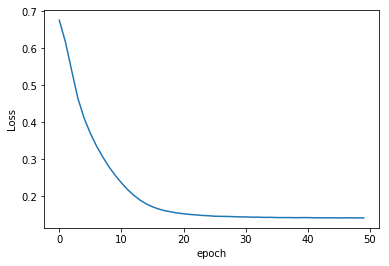

In [33]:
for _ in range(0,50):
    tmlp.train_one_epoch(train_loader)
    if(tmlp.epoch % 10==0):
        accuracy=tmlp.test_accuracy(test_loader)
        print("[Epoch %3d] loss: %.4f accuracy: %.4f" % (tmlp.epoch,tmlp.loss_history[-1],accuracy))

        
plt.plot(tmlp.loss_history)
plt.xlabel("epoch")
plt.ylabel("Loss")

[(-1, 1), Text(0,0.5,'$X_2$'), (-1, 1), Text(0.5,0,'$X_1$'), None]

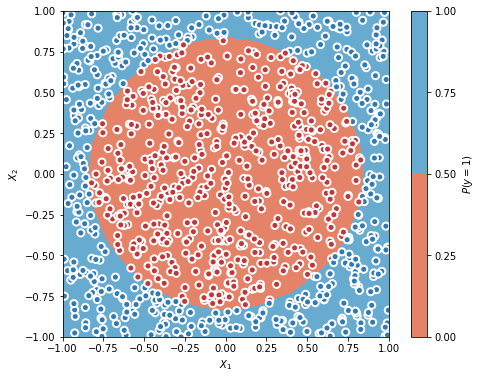

In [34]:
# visualize the decision boundary 

xgrid, ygrid = np.mgrid[-1:1.1:0.1, -1.0:1.1:0.1]
xygrid = np.array([xgrid, ygrid]).transpose(1,2,0)
myinput=torch.Tensor(xygrid.reshape(-1,2))
#     print(myinput.shape)
with torch.no_grad():
    pp=tmlp(myinput)
    probs=pp.numpy().reshape(xgrid.shape)

f, ax = plt.subplots(figsize=(8, 6))
contour = ax.contourf(xgrid, ygrid, probs, [0,0.5,1.0], cmap="RdBu", vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

test=np.load("./test_data.npy")
ax.scatter(test[:,1],test[:,2],c=test[:,0], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=2)

ax.set(aspect="equal",
       xlim=(-1, 1), ylim=(-1, 1),
       xlabel="$X_1$", ylabel="$X_2$")